# Extract Text from Image With Tesseract
This notebook extracts text from the entire image without dividing it into regions.

* First try NO image processing to see how welltesseract can extract text from the BAS graphic.

Intall Py packages:
* pip install pytesseract Pillow opencv-python matplotlib pandas ipython scipy

Use Tesseract command something like:
* pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'



In [1]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Specify the path to tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\bbartling\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# Specify the path to your image
ahu = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu\ahu.jpg'

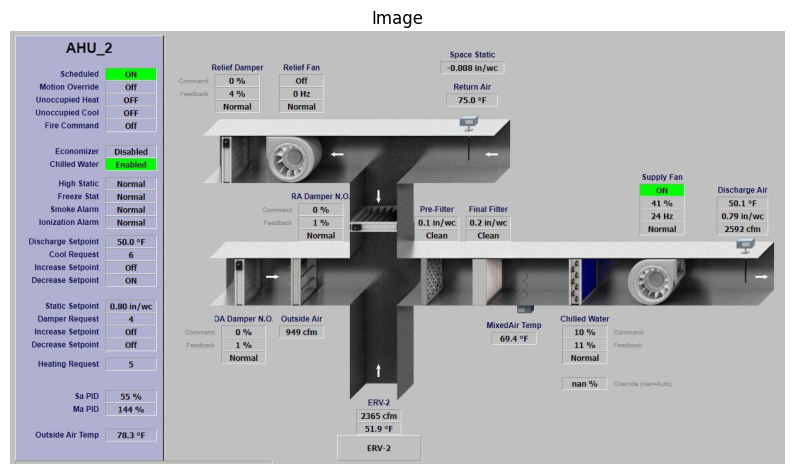

In [2]:

# Function to extract text from an image
def image_to_text(image_path):
    image = cv2.imread(image_path)
    text = pytesseract.image_to_string(image)
    return text

# Function to display the image
def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Display the image
image = cv2.imread(ahu)
display_image(image)

# Extract text from the image
extracted_text_ahu = image_to_text(ahu)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


Preprocessing Steps:

* Grayscale Conversion: Converts the image to grayscale.
* Median Blurring: Reduces noise.
* Adaptive Thresholding: Enhances text detection by making the text stand out.

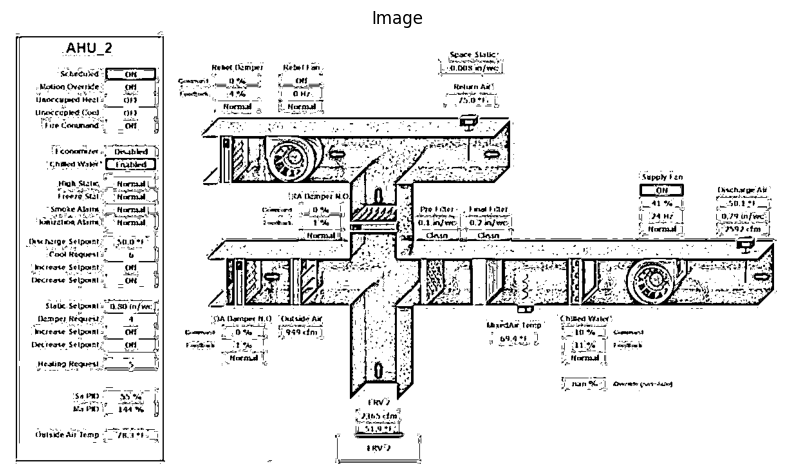

In [3]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return thresh

# Function to extract text from an image
def image_to_text(image_path):
    preprocessed_image = preprocess_image(image_path)
    text = pytesseract.image_to_string(preprocessed_image)
    return text

# Function to display the image
def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Preprocess and display the image
preprocessed_image = preprocess_image(ahu)
display_image(preprocessed_image)

# Extract text from the image
extracted_text_ahu = image_to_text(ahu)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


* Resizing: Upscaling the image can help in better text recognition, especially for small text.
* Edge Detection: Highlighting text boundaries using edge detection.

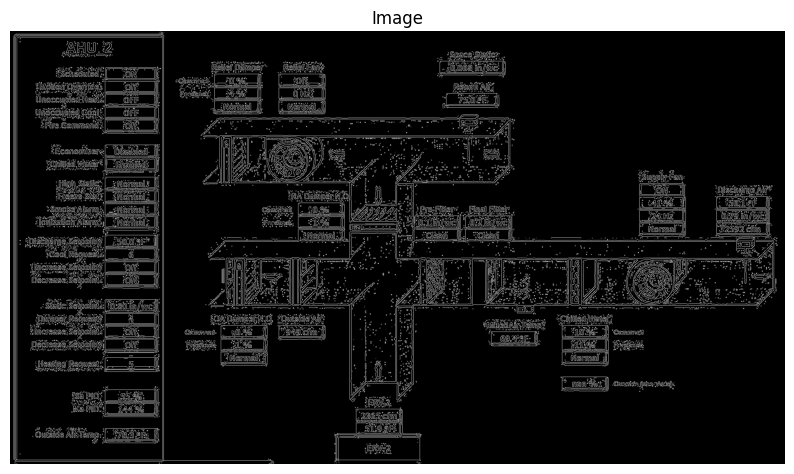

In [4]:
# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Upscaling the image
    scale_percent = 200  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    # Apply edge detection
    edges = cv2.Canny(thresh, 50, 150)
    return edges

# Function to extract text from an image
def image_to_text(image_path):
    preprocessed_image = preprocess_image(image_path)
    text = pytesseract.image_to_string(preprocessed_image)
    return text

# Function to display the image
def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')
    plt.show()


# Preprocess and display the image
preprocessed_image = preprocess_image(ahu)
display_image(preprocessed_image)

# Extract text from the image
extracted_text_ahu = image_to_text(ahu)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


Mild Preprocessing Approach
* Grayscale Conversion: Convert the image to grayscale to reduce complexity.
* Mild Resizing: Upscale the image slightly to help with small text.
* Simple Thresholding: Apply binary thresholding to make the text stand out without excessive blurring.

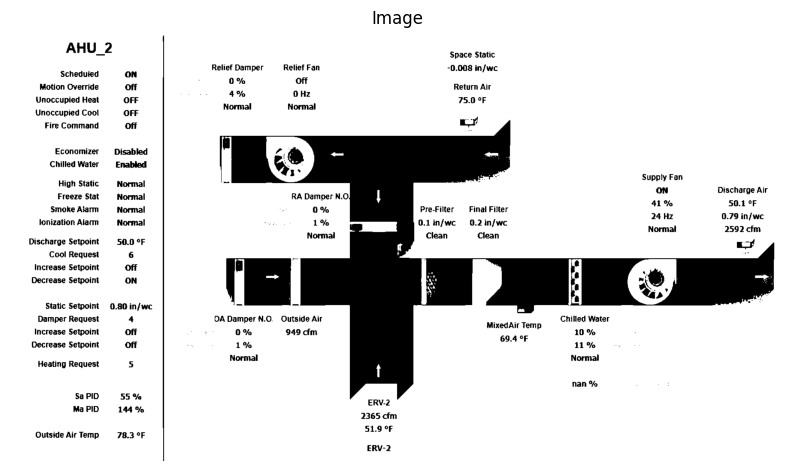

In [5]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Mild upscaling of the image
    scale_percent = 150  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh

# Function to extract text from an image
def image_to_text(image_path):
    preprocessed_image = preprocess_image(image_path)
    text = pytesseract.image_to_string(preprocessed_image)
    return text

# Function to display the image
def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Preprocess and display the image
preprocessed_image = preprocess_image(ahu)
display_image(preprocessed_image)

# Extract text from the image
extracted_text_ahu = image_to_text(ahu)

# Display the extracted text in a scrollable text area
html_output = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
    <pre>{extracted_text_ahu}</pre>
</div>
"""
display(HTML(html_output))


 Tesseract OCR and OpenCV to extract text from an HVAC Building Automation System (BAS) graphic, annotate the detected text, and display the results. The process involves the following steps:

1. **Image Preprocessing**:
   - The image is read and resized to enhance the text detection process.
   - It is then converted to grayscale and binary thresholding is applied to highlight the text.

2. **Text and Coordinate Extraction**:
   - Tesseract OCR is used to extract text and their corresponding coordinates (bounding boxes) from the preprocessed image.
   - The extracted text data includes confidence scores, which are filtered to retain high-confidence results.

3. **Displaying Annotated Image**:
   - The image is annotated with rectangles and text labels indicating the position and content of the detected text.
   - This annotated image is displayed for visual verification.

4. **Displaying Thresholded Image**:
   - The thresholded image used for text detection is displayed to understand the preprocessing effect.

5. **Structured Display of Extracted Text**:
   - The extracted text along with their coordinates is displayed in a scrollable HTML format for easy review.
   - The text data is sorted by coordinates to help identify related components (e.g., sensor names and their values) and presented in a pandas DataFrame for clear and organized analysis.

Import Pandas and df Sort the data by coordinates (x, y)

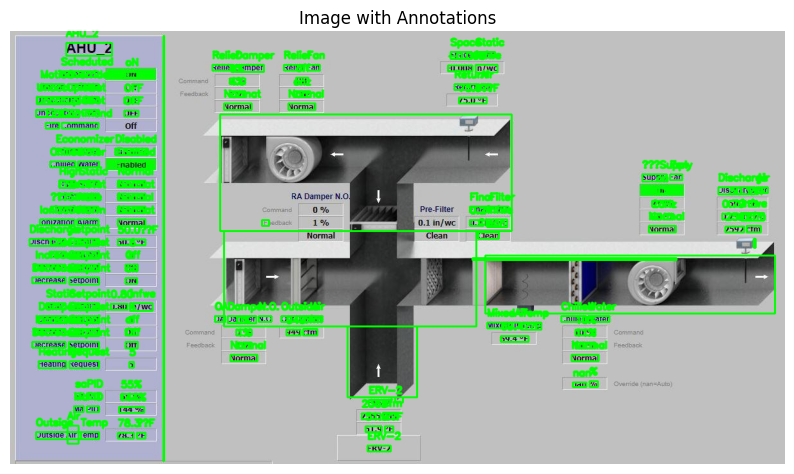

Text,Coordinates
Discharge,"(30, 322, 56, 11)"
Decrease,"(34, 382, 52, 9)"
Decrease,"(34, 482, 52, 9)"
Increase,"(39, 362, 47, 9)"
Increase,"(39, 462, 47, 9)"
Uncccupied,"(40, 122, 67, 11)"
Outsige,"(40, 622, 98, 11)"
Unoccupied,"(41, 102, 67, 11)"
Damper,"(44, 442, 44, 11)"
Heating,"(44, 512, 43, 11)"


In [6]:

import pandas as pd

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))
    
    # Sort the data by coordinates (x, y)
    text_with_coords.sort(key=lambda x: (x[1][0], x[1][1]))
    
    return text_with_coords, original_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()

# Extract text with coordinates
extracted_text_with_coords, original_image = image_to_text_with_coordinates(ahu)

# Display the image with annotated text
display_image_with_annotations(original_image, extracted_text_with_coords)

# Display the extracted text with coordinates in a scrollable text area
sorted_data = sorted(extracted_text_with_coords, key=lambda x: (x[1][0], x[1][1]))
df = pd.DataFrame(sorted_data, columns=["Text", "Coordinates"])

html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))


 Sort the data first by y-coordinate (row) and then by x-coordinate (column)

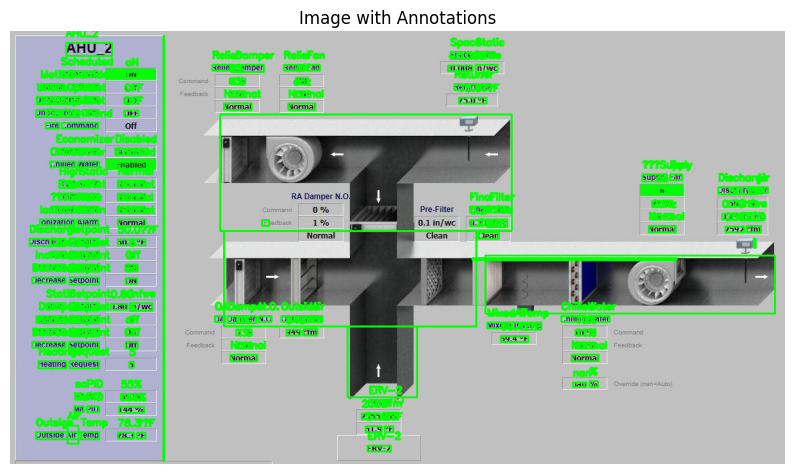

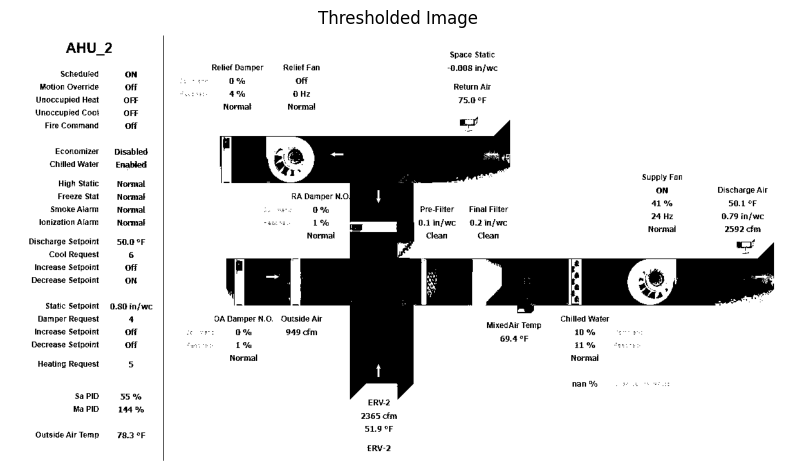

Text,Coordinates
,"(238, 7, 1, 660)"
AHU_2,"(87, 18, 71, 20)"
Space,"(684, 32, 33, 11)"
Static,"(723, 32, 30, 9)"
Relief,"(314, 52, 32, 9)"
Damper,"(350, 52, 44, 11)"
Relief,"(425, 52, 32, 9)"
Fan,"(461, 52, 20, 9)"
infwe,"(723, 52, 34, 12)"
-0.008,"(680, 53, 38, 9)"


In [7]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))
    
    # Sort the data first by y-coordinate (row) and then by x-coordinate (column)
    text_with_coords.sort(key=lambda x: (x[1][1], x[1][0]))
    
    return text_with_coords, original_image, preprocessed_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()

# Function to display the thresholded image
def display_thresholded_image(thresh_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(thresh_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

# Extract text with coordinates
extracted_text_with_coords, original_image, thresh_image = image_to_text_with_coordinates(ahu)

# Display the image with annotated text
display_image_with_annotations(original_image, extracted_text_with_coords)

# Display the thresholded image
display_thresholded_image(thresh_image)

# Convert the DataFrame to an HTML table and display it in a scrollable div
sorted_data = extracted_text_with_coords
df = pd.DataFrame(sorted_data, columns=["Text", "Coordinates"])
html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))


# Chat GPT 4o response:

The AHU (Air Handling Unit) identified as AHU_2 is operating with several sensors and components indicated by the extracted data. The unit is scheduled to be ON, as shown by the "Scheduted" status. Various parameters such as Space Static, Relief Damper, Return Air, and more are actively monitored, with sensor readings like "75.0°F" for return air and "69.4°F" for mixed air temperature. The system is currently in an unoccupied mode, with both heating and cooling functions set to OFF. The economizer is disabled, while the chilled water component is enabled. The supply fan is ON, ensuring airflow through the system. The AHU has several alarms and normal status indicators, such as "Fire Command," "Smoke Alarm," and "Ionization Alarm," all showing normal status, indicating no immediate issues. The discharge air is at 50.1°F with a flow rate of 2592 cfm. The data reflects a comprehensive operational status of the AHU, with detailed sensor readings and component states that ensure the system is functioning within expected parameters.

# Proximity Based sorting for the final output with scipy

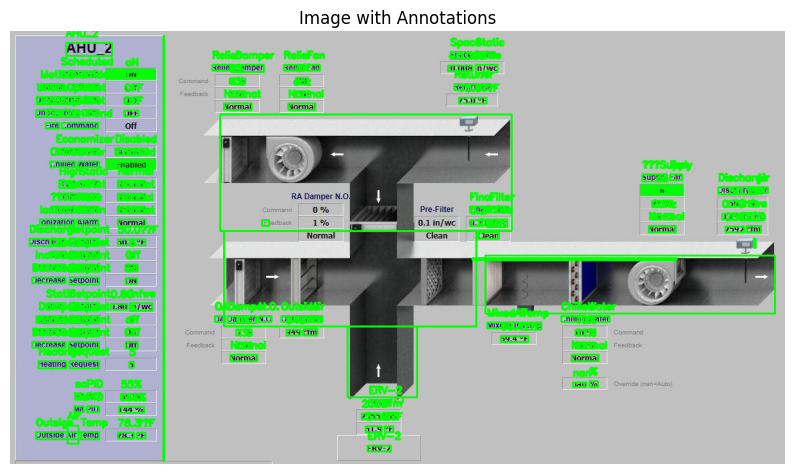

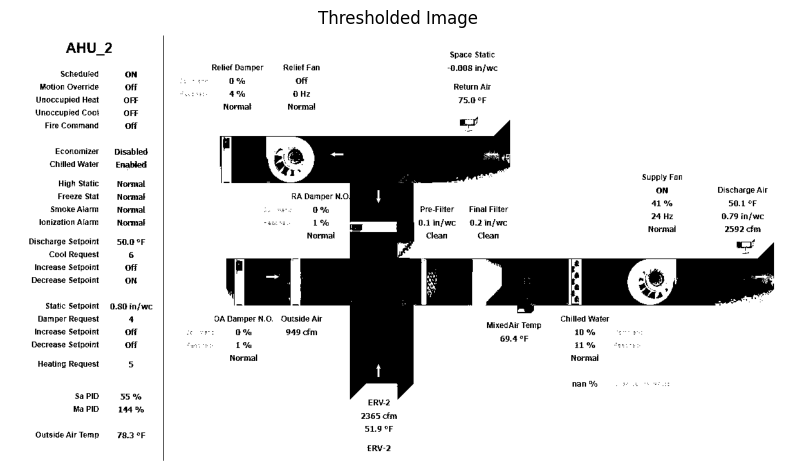

Text,Coordinates
,"(238, 7, 1, 660)"
AHU_2,"(87, 18, 71, 20)"
Space,"(684, 32, 33, 11)"
Static,"(723, 32, 30, 9)"
Relief,"(314, 52, 32, 9)"
Damper,"(350, 52, 44, 11)"
Relief,"(425, 52, 32, 9)"
Fan,"(461, 52, 20, 9)"
infwe,"(723, 52, 34, 12)"
-0.008,"(680, 53, 38, 9)"


In [9]:

from scipy.spatial import distance
import itertools

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))

    # Sort by y-coordinate first
    text_with_coords.sort(key=lambda x: x[1][1])

    # Proximity-based sorting using scipy.spatial.distance
    def sort_by_proximity(coords):
        sorted_coords = [coords.pop(0)]
        while coords:
            last = sorted_coords[-1][1]
            next_index = min(range(len(coords)), key=lambda i: distance.euclidean((last[0], last[1]), (coords[i][1][0], coords[i][1][1])))
            sorted_coords.append(coords.pop(next_index))
        return sorted_coords

    # Group by y-coordinate and sort within each group by proximity
    proximity_sorted_coords = []
    for key, group in itertools.groupby(text_with_coords, key=lambda x: x[1][1]):
        group = list(group)
        proximity_sorted_coords.extend(sort_by_proximity(group))
    
    return proximity_sorted_coords, original_image, preprocessed_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()

# Function to display the thresholded image
def display_thresholded_image(thresh_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(thresh_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

# Extract text with coordinates
extracted_text_with_coords, original_image, thresh_image = image_to_text_with_coordinates(ahu)

# Display the image with annotated text
display_image_with_annotations(original_image, extracted_text_with_coords)

# Display the thresholded image
display_thresholded_image(thresh_image)

# Convert the DataFrame to an HTML table and display it in a scrollable div
df = pd.DataFrame(extracted_text_with_coords, columns=["Text", "Coordinates"])
html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))


# Chat GPT 4o response:

The Air Handling Unit (AHU_2) appears to be operating with various components functioning as indicated by the text annotations and their coordinates. The space temperature is recorded at 75.0°F with the space static pressure at -0.008 in/we. The return air and relief dampers are positioned at 0% and 4% respectively, indicating minimal air exhaust through these pathways. The supply fan is operating at 24 Hz with a discharge airflow of 2592 cfm, maintaining a discharge air temperature of 50.1°F. The system is in an "Unoccupied" mode, with both cooling and heating states shown as "OFF". Several alarms such as "Fire" and "Ionization" are marked as "Normal," indicating no immediate issues. The economizer is disabled, and the chilled water system is enabled. Various static pressure and flow rate measurements are also displayed, highlighting that the system is actively monitoring and controlling airflow and pressure to ensure optimal operation. Additionally, the pre-filter and final filter statuses are marked as "Clean," ensuring efficient air filtration.

### Try optimize the sorting of the pandas DataFrame to reflect how the data appears on the BAS graphic
* The group_text_elements function groups text elements that are close together vertically, within a specified threshold.
* The sort_within_groups function sorts the text elements within each group by their x and y coordinates.
This method should help in organizing the text elements to better reflect their layout on the BAS graphic. You can adjust the threshold value in group_text_elements to fine-tune the grouping based on your specific needs.

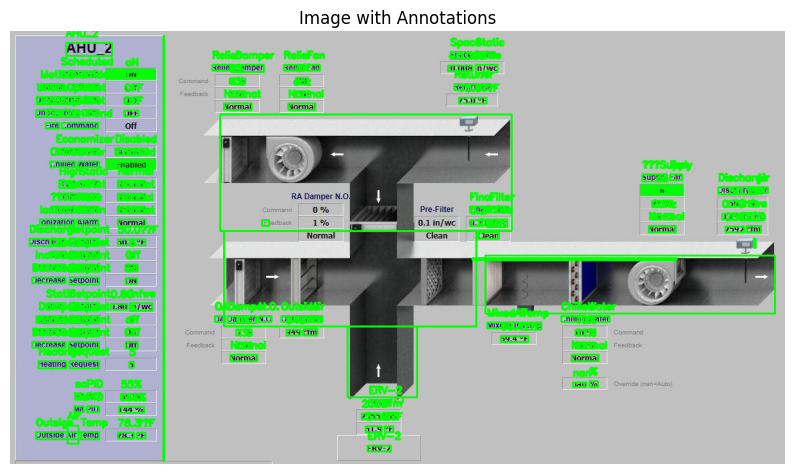

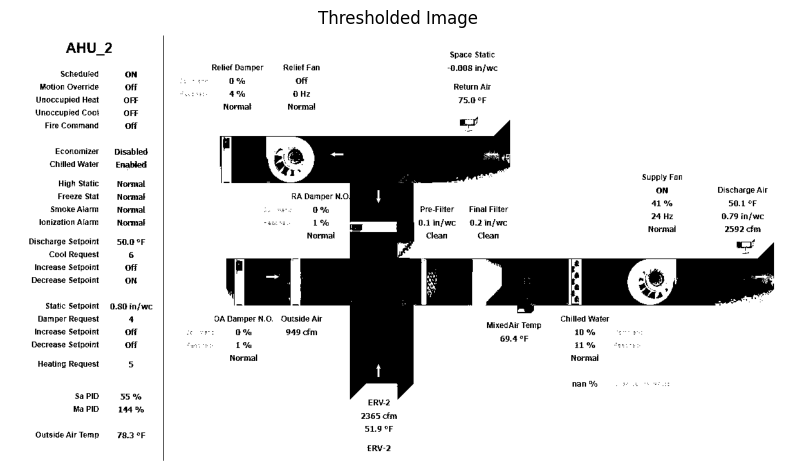

Text,Coordinates
AHU_2,"(87, 18, 71, 20)"
Scheduted,"(79, 62, 58, 9)"
Motion,"(47, 82, 37, 9)"
Override,"(89, 82, 49, 9)"
Unoccupied,"(41, 102, 67, 11)"
Heat,"(113, 102, 25, 9)"
Uncccupied,"(40, 122, 67, 11)"
Coot,"(112, 122, 26, 9)"
Fire,"(55, 142, 21, 9)"
Command,"(80, 142, 57, 9)"


In [10]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))
    
    return text_with_coords, original_image, preprocessed_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()

# Function to display the thresholded image
def display_thresholded_image(thresh_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(thresh_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

# Group text elements by proximity
def group_text_elements(text_with_coords, threshold=50):
    groups = []
    current_group = [text_with_coords[0]]
    
    for text, coords in text_with_coords[1:]:
        last_coords = current_group[-1][1]
        if abs(coords[1] - last_coords[1]) <= threshold:
            current_group.append((text, coords))
        else:
            groups.append(current_group)
            current_group = [(text, coords)]
    groups.append(current_group)
    return groups

# Sort text elements within each group
def sort_within_groups(groups):
    sorted_text_with_coords = []
    for group in groups:
        group.sort(key=lambda x: (x[1][1], x[1][0]))
        sorted_text_with_coords.extend(group)
    return sorted_text_with_coords

# Extract text with coordinates
extracted_text_with_coords, original_image, thresh_image = image_to_text_with_coordinates(ahu)

# Group and sort text elements
groups = group_text_elements(extracted_text_with_coords)
sorted_text_with_coords = sort_within_groups(groups)

# Display the image with annotated text
display_image_with_annotations(original_image, sorted_text_with_coords)

# Display the thresholded image
display_thresholded_image(thresh_image)

# Convert the DataFrame to an HTML table and display it in a scrollable div
df = pd.DataFrame(sorted_text_with_coords, columns=["Text", "Coordinates"])
html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))


Sort by just X

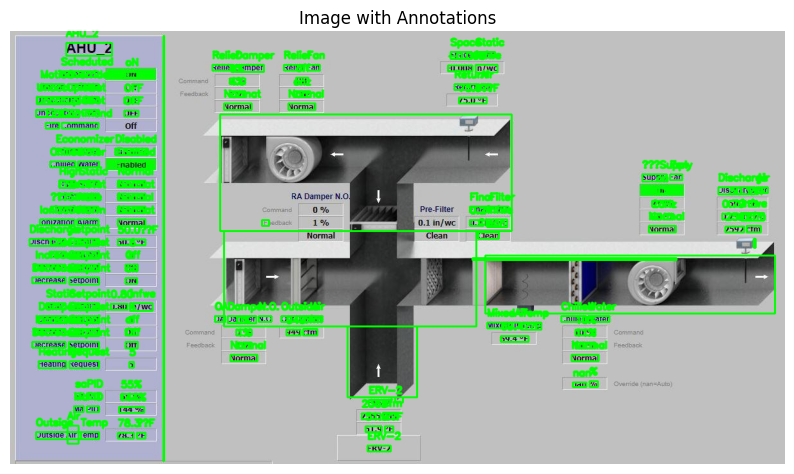

Text,Coordinates
Discharge,"(30, 322, 56, 11)"
Decrease,"(34, 382, 52, 9)"
Decrease,"(34, 482, 52, 9)"
Increase,"(39, 362, 47, 9)"
Increase,"(39, 462, 47, 9)"
Uncccupied,"(40, 122, 67, 11)"
Outsige,"(40, 622, 98, 11)"
Unoccupied,"(41, 102, 67, 11)"
Damper,"(44, 442, 44, 11)"
Heating,"(44, 512, 43, 11)"


In [11]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, image

# Function to extract text and coordinates from an image
def image_to_text_with_coordinates(image_path):
    preprocessed_image, original_image = preprocess_image(image_path)
    data = pytesseract.image_to_data(preprocessed_image, output_type=pytesseract.Output.DICT)
    text_with_coords = []
    n_boxes = len(data['text'])
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Filter out low-confidence results
            text = data['text'][i]
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text_with_coords.append((text, (x, y, w, h)))
    
    # Sort the data by x-coordinate first (column)
    text_with_coords.sort(key=lambda x: x[1][0])
    
    return text_with_coords, original_image

# Function to display the image with annotated text
def display_image_with_annotations(image, annotations):
    for text, (x, y, w, h) in annotations:
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Annotations')
    plt.axis('off')
    plt.show()


# Extract text with coordinates
extracted_text_with_coords, original_image = image_to_text_with_coordinates(ahu)

# Display the image with annotated text
display_image_with_annotations(original_image, extracted_text_with_coords)

# Display the extracted text with coordinates in a scrollable text area
df = pd.DataFrame(extracted_text_with_coords, columns=["Text", "Coordinates"])

html_output = df.to_html(index=False)
html_output = f"<div style='height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>{html_output}</div>"
display(HTML(html_output))
